In [21]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
from collections import Counter
import torch.utils.data as data
import cv2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow




In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Initializing Required Functions

In [4]:
from collections import defaultdict
def CalcDescriptor(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    #print(img.shape,len(kp),len(des))
    return kp,des

def ProcessDataset(loader):

    descriptors = []
    labels = []
    key_points =[]
    images =[]
    descriptor_list = []
    for i, l in loader:
      key=int(l)
  
      x = i.squeeze()
  
      # convert the tensor to a numpy array
      x_np = x.numpy()

      #scaling values and converting data type to uint8 which is needed by the feature extractor
      img_scaled = np.uint8(x_np * 255)
      img_uint8 = cv2.convertScaleAbs(img_scaled)
       
     
      #calling feature extractor
      kp,features = CalcDescriptor(img_uint8)
      #print(len(features))
      # Append the features and label to the dataset
      if features is not None:
        descriptors.append(features)
        
        labels.append(key)
        key_points.append(kp)
        images.append(img_uint8)
    print('Before')
    print(len(descriptors))
    descriptors_list = descriptors
    descriptors = np.vstack(descriptors)
    print('After')
    print(len(descriptors))

    return images,key_points,descriptors,descriptors_list,labels





In [5]:
def ComputeClusters(desc,k):
  # Create a KMeans model with k clusters
  kmeans = KMeans(n_clusters = k, n_init=10)
  kmeans.fit(desc)
  objects_visual_words = kmeans.cluster_centers_

  return objects_visual_words




In [6]:
def find_index(feature, visual_words):
    distances = []
    for word in visual_words:
        distance = np.linalg.norm(feature - word)
        distances.append(distance)
      
    return np.argmin(distances,axis=0)

def image_class(bovw, lables,centers):
    dict_feature = {}
    vec = []
    lab = []
    for i in range(len(bovw)):
        #print(bovw[i],lables[i])
        img = bovw[i]
        histogram = np.zeros(len(centers))
        for each_feature in img:
          ind = find_index(each_feature, centers)
          histogram[ind] += 1
        vec.append(histogram)
          #print(lables[i])
        lab.append(lables[i])
    return vec, lab
    


In [7]:
def VisualizeResults(y_true,y_pred):
  #confusion Matrix
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='.0f', cmap="Blues")
  plt.title("Confusion Matrix")
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show(block=False)

  # Classification Report Visualization
  cr_dict = classification_report(y_true, y_pred, output_dict=True)
  cr_df = pd.DataFrame(cr_dict).transpose()

  sns.heatmap(cr_df.iloc[:-1, :].T, annot=True, fmt='.2f', cmap="Blues")
  plt.title("Classification Report")
  plt.show(block=False)









Objects Dataset

In [8]:

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((256,256)),torchvision.transforms.Grayscale(num_output_channels=1)])

train_data_path = 'drive/MyDrive/A1/Objects_Dataset_Images/train/'
test_data_path = 'drive/MyDrive/A1/Objects_Dataset_Images/test/'

train_dataset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)

test_dataset = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


In [9]:
images,key_points,descriptors,descriptors_list,lables = ProcessDataset(train_loader)
images_test,key_points_test,descriptors_test,descriptors_list_test,lables_test = ProcessDataset(test_loader)

Before
56
After
31339
Before
8
After
4234


In [10]:
visual_words = ComputeClusters(descriptors,35)

In [11]:
# Creates histograms for train data    
x_train, y_train = image_class(descriptors_list,lables, visual_words) 
x_test, y_test = image_class(descriptors_list_test,lables_test, visual_words) 

In [12]:
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

56 56
8 8


In [13]:
clf = SVC()
clf.fit(x_train, y_train)
preds = clf.predict(x_test)


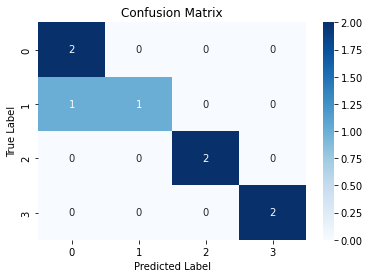

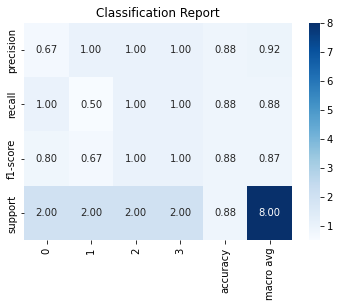

In [14]:
VisualizeResults(y_test,preds)




Wrong Classification
True Lable :  1
Predicted Lable :  0


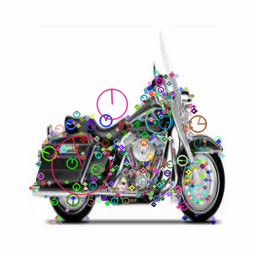

In [26]:
# Draw the keypoints on the image

def display_img(image,kp,label):
    img_kp = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Show the image with keypoints
    cv2_imshow(img_kp)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
#display the first image in the dataset
for i in range(0,len(y_test)):
  if y_test[i] != preds[i]:
    print('Wrong Classification')
    print('True Lable : ', str(y_test[i]))
    print('Predicted Lable : ', str(preds[i]))
    display_img(images[i],key_points[i],lables[i])
    break;

Correct Classification
True Lable :  2
Predicted Lable :  2


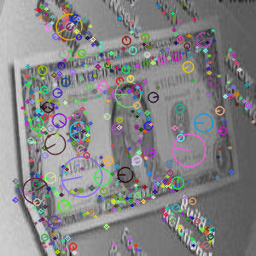

In [27]:
# Draw the keypoints on the image

def display_img(image,kp,label):
    img_kp = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Show the image with keypoints
    cv2_imshow(img_kp)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
#display the first image in the dataset
for i in range(0,len(y_test)):
  if y_test[i] == preds[i]:
    print('Correct Classification')
    print('True Lable : ', str(y_test[i]))
    print('Predicted Lable : ', str(preds[i]))
    display_img(images[i],key_points[i],lables[i])
    break;

In [15]:



# Create the classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
clf_rf.fit(x_train, y_train)

# Predict the labels of the test data
y_pred_rf = clf_rf.predict(x_test)



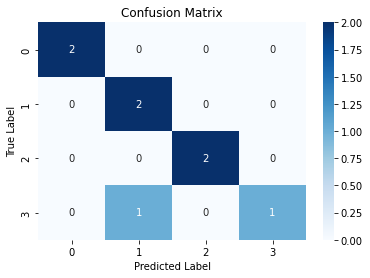

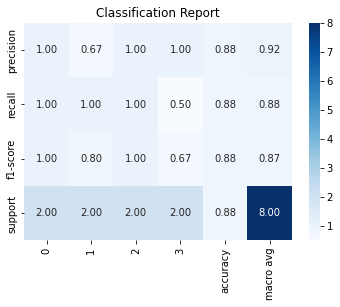

In [16]:
VisualizeResults(y_test,y_pred_rf)


Wrong Classification
True Lable :  3
Predicted Lable :  1


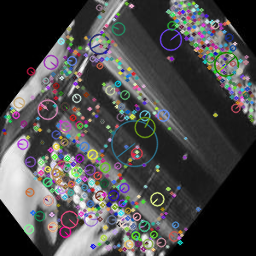

In [24]:
# Draw the keypoints on the image

def display_img(image,kp,label):
    img_kp = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Show the image with keypoints
    cv2_imshow(img_kp)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
#display the first image in the dataset
for i in range(0,len(y_test)):
  if y_test[i] != y_pred_rf[i]:
    print('Wrong Classification')
    print('True Lable : ', str(y_test[i]))
    print('Predicted Lable : ', str(y_pred_rf[i]))
    display_img(images[i],key_points[i],lables[i])
    break;

Correct Classification
True Lable :  1
Predicted Lable :  1


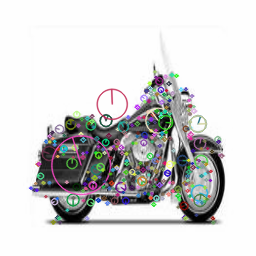

In [25]:
# Draw the keypoints on the image

def display_img(image,kp,label):
    img_kp = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Show the image with keypoints
    cv2_imshow(img_kp)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
#display the first image in the dataset
for i in range(0,len(y_test)):
  if y_test[i] == y_pred_rf[i]:
    print('Correct Classification')
    print('True Lable : ', str(y_test[i]))
    print('Predicted Lable : ', str(y_pred_rf[i]))
    display_img(images[i],key_points[i],lables[i])
    break;

**Flowers Data**

In [17]:
import zipfile

# assume the folder you want to unzip is named "my_folder.zip" and is located in your Google Drive
zip_file_path = '/content/drive/MyDrive/A1/flower_photos.zip'

# extract the contents of the zip file to the current directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('.')


In [28]:

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((256,256)),torchvision.transforms.Grayscale(num_output_channels=1)])



data_path = 'flower_photos/'
dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)


labels = [label for _, label in dataset]

# Count the number of images in each class
class_counts = Counter(labels)

# Print the results
print(class_counts)

Counter({1: 898, 4: 799, 3: 699, 2: 641, 0: 633})


In [29]:
f_images,f_key_points,f_descriptors,f_descriptors_list,f_lables = ProcessDataset(data_loader)



Before
3670
After
1898159


In [30]:
f_visual_words = ComputeClusters(f_descriptors, 50)

In [31]:
f_vec, f_lab = image_class(f_descriptors_list,f_lables, f_visual_words)

In [32]:
fx_train, fx_test, fy_train, fy_test = train_test_split(f_vec, f_lab, test_size=0.2)

In [33]:
print(len(fx_train),len(fy_train))
print(len(fx_test),len(fy_test))

2936 2936
734 734


In [34]:

clf = SVC()
clf.fit(fx_train, fy_train)
f_preds = clf.predict(fx_test)


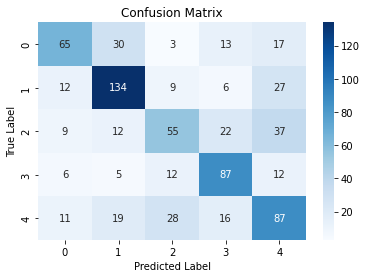

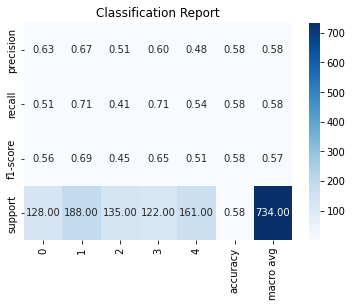

In [35]:
VisualizeResults(fy_test,f_preds)

In [36]:
# Create the classifier
f_clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
f_clf_rf.fit(fx_train, fy_train)

# Predict the labels of the test data
f_y_pred_rf = f_clf_rf.predict(fx_test)


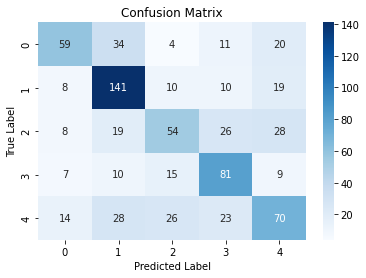

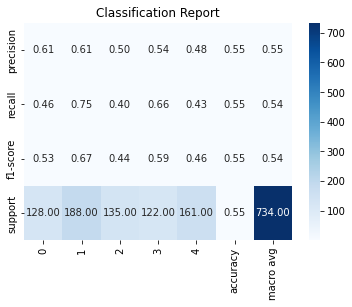

In [37]:
VisualizeResults(fy_test,f_y_pred_rf)

Wrong Classification
True Lable :  1
Predicted Lable :  4


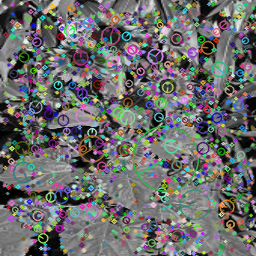

In [38]:
# Draw the keypoints on the image

def display_img(image,kp,label):
    img_kp = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Show the image with keypoints
    cv2_imshow(img_kp)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
#display the first image in the dataset
for i in range(0,len(fy_test)):
  if fy_test[i] != f_y_pred_rf[i]:
    print('Wrong Classification')
    print('True Lable : ', str(fy_test[i]))
    print('Predicted Lable : ', str(f_y_pred_rf[i]))
    display_img(f_images[i],f_key_points[i],f_lables[i])
    break;

Correct Classification
True Lable :  2
Predicted Lable :  2


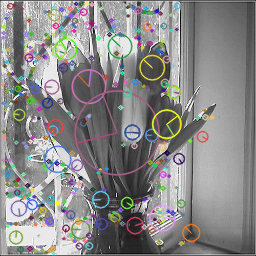

In [39]:
# Draw the keypoints on the image

def display_img(image,kp,label):
    img_kp = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Show the image with keypoints
    cv2_imshow(img_kp)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
#display the first image in the dataset
for i in range(0,len(fy_test)):
  if fy_test[i] == f_y_pred_rf[i]:
    print('Correct Classification')
    print('True Lable : ', str(fy_test[i]))
    print('Predicted Lable : ', str(f_y_pred_rf[i]))
    display_img(f_images[i],f_key_points[i],f_lables[i])
    break;